# Integrated Project 2 - Gold Extraction Model

## Project Description

The data you need is stored in three files:
- gold_recovery_train.csv
- gold_recovery_test.csv
- gold_recovery_full.csv

This data is indexed according to the date and time it was obtained (date feature). Regarding time, parameters that are located next to each other are generally similar.
Some parameters are not available because their measurements and/or calculations were carried out much later. That is why, some features that are in the training set may not be present in the test set. The test set also does not contain targets.
The source dataset contains the training and test sets with all their features.

### Data Description

Technological Process:
- `Rougher feed` — raw material for the flotation process
- `Rougher additions` (or reagent additions) — reagents for flotation: Xanthate, Sulphate, Depressant
- `Xanthate` — flotation activator or activator
- `Sulphate` — sodium sulfide, specifically for this process
- `Depressant` — sodium silicate
- `Rougher process` — flotation
- `Rougher tails` — product residue
- `Float banks` — flotation units
- `Cleaner process` — purification
- `Rougher Au` — a coarser gold concentrate
- `Final Au` — final gold concentrate
- Parameters of the Available Stages
- `air amount` — air volume
- `fluid levels`
- `feed size` — the size of the feed particles
- `feed rate`

### Feature Naming

Here is how to give names to existing features:

[stage].[parameter_type].[parameter_name]

Example: rougher.input.feed_ag

Possible values for [stage]:
- `rougher — flotation
- `primary_cleaner — first cleanup
- `secondary_cleaner — secondary cleaning
- `final — final characteristic

Possible values for [parameter_type]:
- `input` — raw material parameters
- `output` — product parameters
- `state` — parameters indicating the characteristics of the current stage
- `calculation` — calculation of characteristics

### Project Plan

By obtaining the data that will be used in this project, there are several steps that will be taken to calculate the metal concentrate value using the best model and error calculations based on symmetric errors as required by the company, there are several plans as follows:
- Initialization
- Data Overview
    - Data checking is carried out first so that the data visualization is clear and to check if there are duplicate values, missing values or other problems
- Data Pre-Processing
    - The process of filling in missing values is done by filling in whatever value is needed
    - Data that has passed data pre-processing is final data that is safe to use in the model training process
- Data Analysis 
    - Analysis of the features contained in the data is necessary so that when modeling, the data used does not experience errors
- Modelling
    - Model training using several models is used to find the best model to produce a value
- General conclusion at the end of the process which aims to summarize the entire process from start to finish

## Initialization

In [1]:
# import general and machine learning library

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
pd.set_option('display.max.columns', 100)
warnings.filterwarnings('ignore')

## Data Overview

In [2]:
data_train = pd.read_csv('gold_recovery_train.csv', parse_dates=True)
data_test = pd.read_csv('gold_recovery_test.csv', parse_dates=True)
data_full = pd.read_csv('gold_recovery_full.csv', parse_dates=True)

In [3]:
data_train.shape, data_test.shape, data_full.shape

((16860, 87), (5856, 53), (22716, 87))

**Findings :**

In preparing the data, it was discovered that the test data did not have full columns like the training data or full data, therefore it will be analyzed later to determine whether the test data will be added or the training data will have columns reduced to determine a model.

## Data Pre-Processing

### MAE Checking

include :
- Check the gold
- Count (rougher.output.recovery)
- Find MAE

In [4]:
data_train_mae = data_train.copy()

In [5]:
data_train_mae['numerator'] = data_train_mae['rougher.output.concentrate_au']*(data_train_mae['rougher.input.feed_au']-data_train_mae['rougher.output.tail_au'])
data_train_mae['denumerator'] = data_train_mae['rougher.input.feed_au']*(data_train_mae['rougher.output.concentrate_au']-data_train_mae['rougher.output.tail_au'])

In [6]:
data_train_mae[['numerator', 'denumerator']].isnull().sum()

numerator      2250
denumerator    2250
dtype: int64

In [7]:
data_train_mae['numerator'] = data_train_mae['numerator'].fillna(0)
data_train_mae['denumerator'] = data_train_mae['denumerator'].fillna(1)

In [8]:
data_train_mae['mae'] = data_train_mae['numerator'] / data_train_mae['denumerator'] * 100

In [9]:
print('MAE between measured value and feature is', (data_train_mae['mae'] - data_train_mae['rougher.output.recovery']).abs().mean())

MAE between measured value and feature is 9.303415616264301e-15


**Findings :**
- To get a rough concentrate, a comparison is needed between the gold concentrate and the tail, so a fraction and denominator are needed which have been divided into 'numerator' and 'denumerator' data.
- Missing values in the two data that have been separated will respectively be replaced with values 0 and 1, to make calculations easier
- After the calculation is carried out to get the rough concentrate value, a comparison will be made with the previously existing rough concentrate results, in other words the MAE value will be looked for
- The MAE value or simply the error that occurs between the value in the calculation and the existing value is very small, namely 9.303415616264301e-15, where this value will not be a problem for further analysis

### Feature Analysis
- Not included in Test Data
- Type of parameter

In [10]:
missed_columns = set(list(data_train.columns.values)) - set(list(data_test.columns.values))
missed_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [11]:
data_full[missed_columns].dtypes

rougher.calculation.au_pb_ratio                       float64
primary_cleaner.output.tail_au                        float64
primary_cleaner.output.concentrate_pb                 float64
final.output.concentrate_au                           float64
rougher.output.tail_pb                                float64
rougher.output.concentrate_sol                        float64
final.output.tail_ag                                  float64
rougher.output.tail_ag                                float64
rougher.calculation.floatbank10_sulfate_to_au_feed    float64
secondary_cleaner.output.tail_pb                      float64
rougher.output.concentrate_ag                         float64
primary_cleaner.output.tail_sol                       float64
rougher.calculation.sulfate_to_au_concentrate         float64
primary_cleaner.output.concentrate_sol                float64
final.output.concentrate_sol                          float64
secondary_cleaner.output.tail_au                      float64
final.ou

In [12]:
data_test_full = data_full[(data_full['date'].isin(data_test['date']))].reset_index(drop=True)
data_test_full.shape

(5856, 87)

**Findings :**

- Missing columns in the test data column include the 'rougher.input.recovery' and 'final.output.recovery' columns, where these 2 columns are parameters that will be used as calculations in this project
- Create test data that uses all 87 columns in accordance with full data as data that will be used for further analysis needs

### Checking Missing Values

In [13]:
data_train.isnull().sum().sort_values(ascending=False).head()

rougher.output.recovery              2573
rougher.output.tail_ag               2250
rougher.output.tail_sol              2249
rougher.output.tail_au               2249
secondary_cleaner.output.tail_sol    1986
dtype: int64

In [14]:
data_test.isnull().sum().sort_values(ascending=False).head()

rougher.input.floatbank11_xanthate    353
primary_cleaner.input.sulfate         302
primary_cleaner.input.depressant      284
rougher.input.floatbank10_sulfate     257
primary_cleaner.input.xanthate        166
dtype: int64

In [15]:
data_full.isnull().sum().sort_values(ascending=False).head()

rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_au                2736
rougher.output.tail_sol               2736
rougher.input.floatbank11_xanthate    2257
dtype: int64

In [16]:
data_test_full.isnull().sum().sort_values(ascending=False).head()

rougher.output.recovery    546
rougher.output.tail_ag     487
rougher.output.tail_au     487
rougher.output.tail_sol    487
final.output.recovery      442
dtype: int64

All data has missing values, therefore several ways will be taken to overcome these missing values in the next analysis

## Data Analysis

### Metal Concentration Progress

In [17]:
steps_progress = [
    'rougher.input.feed_{}',
    'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}',
    'final.output.concentrate_{}'
]

def concentrate_progress(component):
    steps = [s.format(component) for s in steps_progress]
    for step in steps:
        data_full[step].hist(alpha=0.5, bins=25)
    plt.legend(steps)

Text(0.5, 1.0, 'Silver')

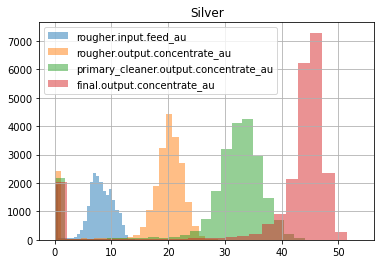

In [18]:
concentrate_progress('au')
plt.title('Silver')

Text(0.5, 1.0, 'Gold')

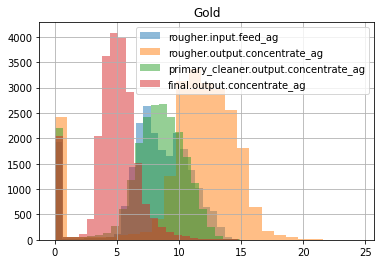

In [19]:
concentrate_progress('ag')
plt.title('Gold')

Text(0.5, 1.0, 'Lead')

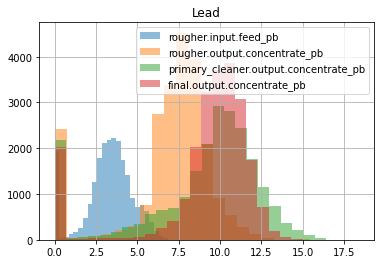

In [20]:
concentrate_progress('pb')
plt.title('Lead')

**Findings :**

- Silver metal has a gradual process which starts with a mixture of ore with a low concentration level, then after the flotation process produces a higher concentration and finally the final concentrate after refining produces the highest concentration level compared to before.
- In contrast to gold metal, where the metal in its initial state is still a mixture of ores, has a higher concentration level compared to the final concentrate which has gone through 2 refining times.
- For lead metal, the concentration level in the final concentrate is not too different from the results before or after refining, although it is quite different from the ore mixture

### Comparison of Particle Distribution between Training and Test Data

<AxesSubplot:ylabel='Density'>

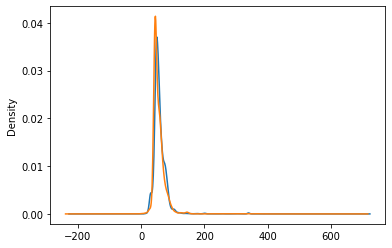

In [21]:
data_train['rougher.input.feed_size'].plot.kde()
data_test['rougher.input.feed_size'].plot.kde()

In [22]:
def outlier(series):
    return series[series.between(series.quantile(0.01), series.quantile(0.99))]

def compare_train_test(feature):
    outlier(data_train[feature]).plot.kde()
    outlier(data_test[feature]).plot.kde()
    plt.legend(['train', 'test'])

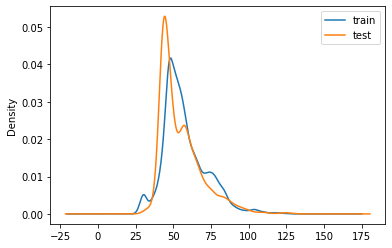

In [23]:
compare_train_test('rougher.input.feed_size')

**Findings :**

- Outliers contained in the data will be removed, such as missing values, to make it look more realistic
- After eliminating outliers, the graph formed shows a fairly equal size comparison between the training data and the test data
- Even before removing outliers, the graph formed is not too different from after removing outliers, so there is no significant difference

### Consider Total Concentration of all Substances

<AxesSubplot:>

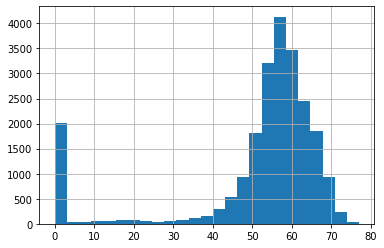

In [24]:
input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol'
]

data_full[input_concentrate].sum(1).hist(bins=25)

<AxesSubplot:>

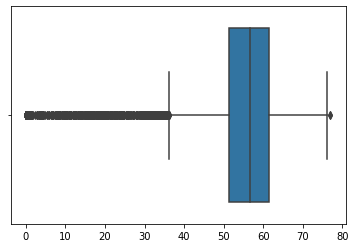

In [25]:
sns.boxplot(data_full[input_concentrate].sum(1))

<AxesSubplot:>

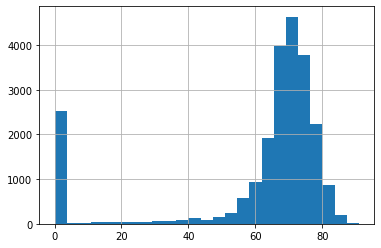

In [26]:
output_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol'
]

data_full[output_concentrate].sum(1).hist(bins=25)

<AxesSubplot:>

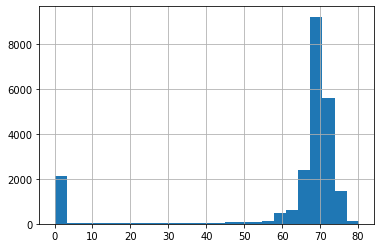

In [27]:
final_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol'
]

data_full[final_concentrate].sum(1).hist(bins=25)

In [28]:
divide = 0.1

data_train = data_train[data_train[input_concentrate].sum(1)>divide]
data_train = data_train[data_train[output_concentrate].sum(1)>divide]
data_train = data_train[data_train[final_concentrate].sum(1)>divide]

data_test_fix = data_test[data_test_full[input_concentrate].sum(1)>divide]
data_test_fix = data_test[data_test_full[output_concentrate].sum(1)>divide]
data_test_fix = data_test[data_test_full[final_concentrate].sum(1)>divide]

print(data_train.shape)
print(data_test_fix.shape)

(14601, 87)
(5490, 53)


**Findings :**

- Missing values greatly affect outliers as shown in the graph and boxplot
- For the mixture of initial ore and coarse concentrate, the average concentration level is above 40, while for the final concentrate, the average value is above 60.
- To overcome missing values, constraints will be used to reduce them so that in subsequent model analysis, it can look more realistic

### Handle Missing Values

In [29]:
columns_fix = data_test.columns.values.tolist()
columns_fix.append('rougher.output.recovery')
columns_fix.append('final.output.recovery')

In [30]:
data_train_final = data_train[columns_fix]

In [31]:
data_train_final = data_train_final[data_train_final['rougher.output.recovery'].notnull()].reset_index(drop=True)
data_train_final = data_train_final[data_train_final['final.output.recovery'].notnull()].reset_index(drop=True)

In [32]:
data_full_final = pd.concat([data_train_final, data_test])

In [33]:
data_train_final.shape, data_full_final.shape

((13789, 55), (19645, 55))

In [34]:
data_full_final.isnull().sum().sort_values(ascending=False)

final.output.recovery                         5856
rougher.output.recovery                       5856
rougher.input.floatbank11_xanthate             748
rougher.state.floatbank10_e_air                390
primary_cleaner.input.sulfate                  321
primary_cleaner.input.depressant               310
rougher.input.floatbank10_sulfate              286
primary_cleaner.input.xanthate                 262
secondary_cleaner.state.floatbank2_a_air       233
rougher.input.feed_size                        161
rougher.input.feed_sol                         142
rougher.input.floatbank10_xanthate             130
rougher.input.feed_pb                          116
rougher.input.floatbank11_sulfate               83
rougher.input.feed_rate                         48
secondary_cleaner.state.floatbank2_b_air        42
secondary_cleaner.state.floatbank3_a_air        38
secondary_cleaner.state.floatbank4_a_air        20
primary_cleaner.state.floatbank8_b_air          20
primary_cleaner.state.floatbank

**Findings :**

- Training data will use the same number of columns as test data, plus 2 columns, namely 'rougher.output.recovery' and 'final.output.recovery'
- New full data is created by adding up the training data and test data, where the missing values in the 2 columns above will no longer be used
- With a new dataset, the number of rows is reduced considering that missing values are no longer used

***Function for missing values with median***

In [35]:
for column in data_full_final.isnull().sum().sort_values(ascending=False)[2:-2].index:
    median_column = data_full_final[column].median()
    data_full_final[column] = data_full_final[column].fillna(median_column)

In [36]:
data_test_final = data_full_final[data_full_final['rougher.output.recovery'].isnull()]
data_test_final = data_test_final.drop(columns=['rougher.output.recovery', 'final.output.recovery'])

data_train_final = data_full_final[data_full_final['rougher.output.recovery'].notnull()].reset_index(drop=True)

In [37]:
data_train_final.shape, data_test_final.shape

((13789, 55), (5856, 53))

**FIndings :**
- The new dataset for testing is created using the new full data and removing the 'rougher.output.recovery' and 'final.output.recovery' columns because these 2 columns will be used as targets in model training
- To overcome missing values in several columns in the new training data and test data, the missing values are filled in with the median

## Modelling

### Function for Final sMAPE

In [38]:
features = data_test_final.drop(columns=['date']).columns.values
targets = ['rougher.output.recovery', 'final.output.recovery']

In [39]:
features_train = data_train_final[features].reset_index(drop=True)
target_train = data_train_final[targets].reset_index(drop=True)

target_train.columns = [0, 1]

In [40]:
features_test = data_test_final[features].reset_index(drop=True)
target_test = data_test_full[targets]

target_test.columns = [0, 1]

In [41]:
features_train.shape, features_test.shape

((13789, 52), (5856, 52))

In [42]:
def sMAPE(y_forecast, y_actual):
    error_value = (y_forecast - y_actual).abs()
    exact_value = (y_forecast.abs() + y_actual.abs()) / 2
    return (error_value / exact_value).mean()*100

def end_sMAPE(y_forecast, y_actual):
    rougher = sMAPE(y_forecast[0], y_actual[0])
    final = sMAPE(y_forecast[1], y_actual[1])
    return 0.25*rougher + 0.75*final

In [43]:
train_prediction = target_train.copy()
train_prediction[0] = target_train[0].median()
train_prediction[1] = target_train[1].median()
print('Prediction for Train Data :', end_sMAPE(target_train, train_prediction))

Prediction for Train Data : 9.448962714511023


In [44]:
test_prediction = target_test.copy()
test_prediction[0] = target_test[0].median()
test_prediction[1] = target_test[1].median()
print('Prediction for Test Data :', end_sMAPE(target_test, test_prediction))

Prediction for Test Data : 9.625892667445223


**Findings :**

- The prediction error in the training data is 9.448962714511023
- Prediction error in testing data is worth 9.625892667445223
- There is not much value between training data and test data, although the resulting value can be considered large for an error

### Model Evaluated with Cross Validation

In [45]:
def score(model, cv=4):
    scores = []
    
    for subtrain, valid in KFold(n_splits=cv).split(features_train):
        features_subtrain = features_train.loc[subtrain].reset_index(drop=True)
        target_subtrain = target_train.loc[subtrain].reset_index(drop=True)
        
        features_valid = features_train.loc[valid].reset_index(drop=True)
        target_valid = target_train.loc[valid].reset_index(drop=True)
        
        model.fit(features_subtrain, target_subtrain)
        prediction_valid = pd.DataFrame(model.predict(features_valid))
        scores.append(end_sMAPE(target_valid, prediction_valid))
    
    return pd.Series(scores).mean()

**Linear Regression**

In [46]:
lr = LinearRegression()
lr_score = score(lr)
lr_score

10.245510639692792

**Decision Tree Regression**

In [47]:
for depth in range (1, 6):
    dt = DecisionTreeRegressor(random_state=1, max_depth=depth)
    dt_score = score(dt)   

    print("Best Score for Decision Tree:", dt_score, "best_depth:", depth)

Best Score for Decision Tree: 10.236557749891972 best_depth: 1
Best Score for Decision Tree: 10.027153214115845 best_depth: 2
Best Score for Decision Tree: 9.702076755210783 best_depth: 3
Best Score for Decision Tree: 9.744153239185234 best_depth: 4
Best Score for Decision Tree: 10.083589556220396 best_depth: 5


**Random Forest Regression**

In [49]:
for est in range(10, 51, 10):
    for depth in range (1, 6):
        rf = RandomForestRegressor(random_state=1, max_depth=depth, n_estimators=est)
        rf_score = score(rf)

        print("Best Score for Random Forest:", rf_score, "best_depth:", depth, "best_est:", est)            

Best Score for Random Forest: 10.232336610328037 best_depth: 1 best_est: 10
Best Score for Random Forest: 9.811943065776434 best_depth: 2 best_est: 10
Best Score for Random Forest: 9.429485738771774 best_depth: 3 best_est: 10
Best Score for Random Forest: 9.423745040061146 best_depth: 4 best_est: 10
Best Score for Random Forest: 9.745623534515136 best_depth: 5 best_est: 10
Best Score for Random Forest: 10.208001897847204 best_depth: 1 best_est: 20
Best Score for Random Forest: 9.809980338360521 best_depth: 2 best_est: 20
Best Score for Random Forest: 9.376189374679385 best_depth: 3 best_est: 20
Best Score for Random Forest: 9.357017191155036 best_depth: 4 best_est: 20
Best Score for Random Forest: 9.546141839616375 best_depth: 5 best_est: 20
Best Score for Random Forest: 10.201606068849328 best_depth: 1 best_est: 30
Best Score for Random Forest: 9.792283125099392 best_depth: 2 best_est: 30
Best Score for Random Forest: 9.365936467350465 best_depth: 3 best_est: 30
Best Score for Random 

**Findings :**

- The resulting value in linear regression is 10.245510639692792
- The best value produced by decision tree regression is at depth 3 with a value of 9.702076755210783
- The best value produced by random forest regression is the 30 depth 4 estimator with a value of 9.32601282766173
- The best model to use is random forest regression, considering that this model produces a small error compared to previous predictions

### Best Model for Test Sample

In [52]:
best_model = RandomForestRegressor(max_depth=4, n_estimators=30, random_state=1)
best_model.fit(features_train, target_train)

prediction_train = pd.DataFrame(best_model.predict(features_train))
prediction_test = pd.DataFrame(best_model.predict(features_test))

print('Train Value :', end_sMAPE(target_train, prediction_train))
print('Test Value :', end_sMAPE(target_test, prediction_test))

Train Value : 7.07145934718067
Test Value : 10.18966809276858


## General Conclusion

- Columns used in both data, both training data and testing data, must have the same number, same column names, and have no missing values
- Missing values in the columns in both data can be replaced by any number or by the median depending on needs
- It is also very important to remove outliers to make it easier and to get results that match reality during the analysis and modeling process
- In the calculation to find the rough concentrate value, it was found that the calculated value and the actual value were not much different, it could be said that the resulting error was very small, where the number obtained was 9.303415616264301e-15
- The process of producing concentrate values for several types of metal produces different graphs
- The changes in particles used in the training data and testing data show no different graphs (after removing outlier values), so that the results obtained in the next step can be said to be safe
- By taking into account the target scale and predictions, the best model used to calculate sMAPE is the Random Forest Regression model with the conditions, depth=4 n_estimator=30
- The results obtained in the regression are worth 10.18966809276858 in the final prediction of the testing data